In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from keras.models import Model
from keras.layers import Input, Dense

from evaluation import model_evaluation, backtest

2024-05-24 00:26:17.785199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Load the data
stats = pd.read_csv('data/PlayersStats_1971-2024.csv')
rookies = pd.read_csv('data/Rookies_1971-2024.csv')[['href', 'Year']]
stats = rookies.merge(stats, on = ['href', 'Year'], how = 'left')
shares = pd.read_csv('data/SharesROY_1971-2024.csv')

# Merge stats and shares
data = stats.merge(shares, how = 'left', on = ['href', 'Year'], suffixes = ['', '_y']).drop(columns = ['Player_y'])
data = data[data['Year'] >= 1980]
data = data.fillna(0.)
data = data[((data['G'] >= 10) & (data['MP'] >= 4)) | (data['Share'] > 0)]
data = data.reset_index(drop = True)

start_year = 1988

In [12]:
features = ['PTS', 'VORP', 'FG', 'WS', 'MP', 'GS', 'TRB', 'AST', 'PER', 'BPM']
features_norm = features

In [13]:
# Calculate means and stds by year
means = data.groupby('Year')[features_norm].transform('mean')
stds = data.groupby('Year')[features_norm].transform('std')

# Standardize features
data_norm = data.copy()
data_norm[features_norm] = (data[features_norm] - means) / stds

In [14]:
def summarize_backtest(backtests) :
    for metric in backtests.columns[-7:] :
        print(metric, backtests[metric].mean())

In [15]:
def create_nn(hidden_layers, end_activation = 'sigmoid') :

    # Input layer
    inputs = Input(shape = (len(features),))

    x = Dense(hidden_layers[0], activation = 'relu')(inputs)
    if len(hidden_layers) > 1 :
        for hidden in hidden_layers[1:] :
            x = Dense(hidden, activation = 'relu')(x)

    # Output layer
    outputs = Dense(1, activation = end_activation)(x)

    # Construct the model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['mse', 'mae'])
    
    return model

In [16]:
# 1. Linear Regression
lr = LinearRegression()

# 2. Random Forest
rf = RandomForestRegressor(n_estimators = 250, max_depth = 12)

# 3. XGBoost
xg = xgb.XGBRegressor(n_estimators = 150, learning_rate = 0.2)

# 4. Neural Network
nn = create_nn([64, 32, 16])

In [21]:
# Run backtests
backtest_lr = backtest(start_year, data.copy(), lr, features)
backtest_rf = backtest(start_year, data_norm.copy(), rf, features)
backtest_xg = backtest(start_year, data.copy(), xg, features)
backtest_nn = backtest(start_year, data_norm.copy(), nn, features, keras = (10, 32))

[1/37] ... 1988 ...   
[2/37] ... 1989 ...   
[3/37] ... 1990 ...   
[4/37] ... 1991 ...   
[5/37] ... 1992 ...   
[6/37] ... 1993 ...   
[7/37] ... 1994 ...   
[8/37] ... 1995 ...   
[9/37] ... 1996 ...   
[10/37] ... 1997 ...   
[11/37] ... 1998 ...   
[12/37] ... 1999 ...   
[13/37] ... 2000 ...   
[14/37] ... 2001 ...   
[15/37] ... 2002 ...   
[16/37] ... 2003 ...   
[17/37] ... 2004 ...   
[18/37] ... 2005 ...   
[19/37] ... 2006 ...   
[20/37] ... 2007 ...   
[21/37] ... 2008 ...   
[22/37] ... 2009 ...   
[23/37] ... 2010 ...   
[24/37] ... 2011 ...   
[25/37] ... 2012 ...   
[26/37] ... 2013 ...   
[27/37] ... 2014 ...   
[28/37] ... 2015 ...   
[29/37] ... 2016 ...   
[30/37] ... 2017 ...   
[31/37] ... 2018 ...   
[32/37] ... 2019 ...   
[33/37] ... 2020 ...   
[34/37] ... 2021 ...   
[35/37] ... 2022 ...   
[36/37] ... 2023 ...   
[37/37] ... 2024 ...   
[1/37] ... 1988 ...   
[2/37] ... 1989 ...   
[3/37] ... 1990 ...   
[4/37] ... 1991 ...   
[5/37] ... 1992 ...   
[6/37]

Linear Reg. :  75.7%
Random Forest :  75.7%
XGBoost :  56.8%
Neural Net. :  73.0%


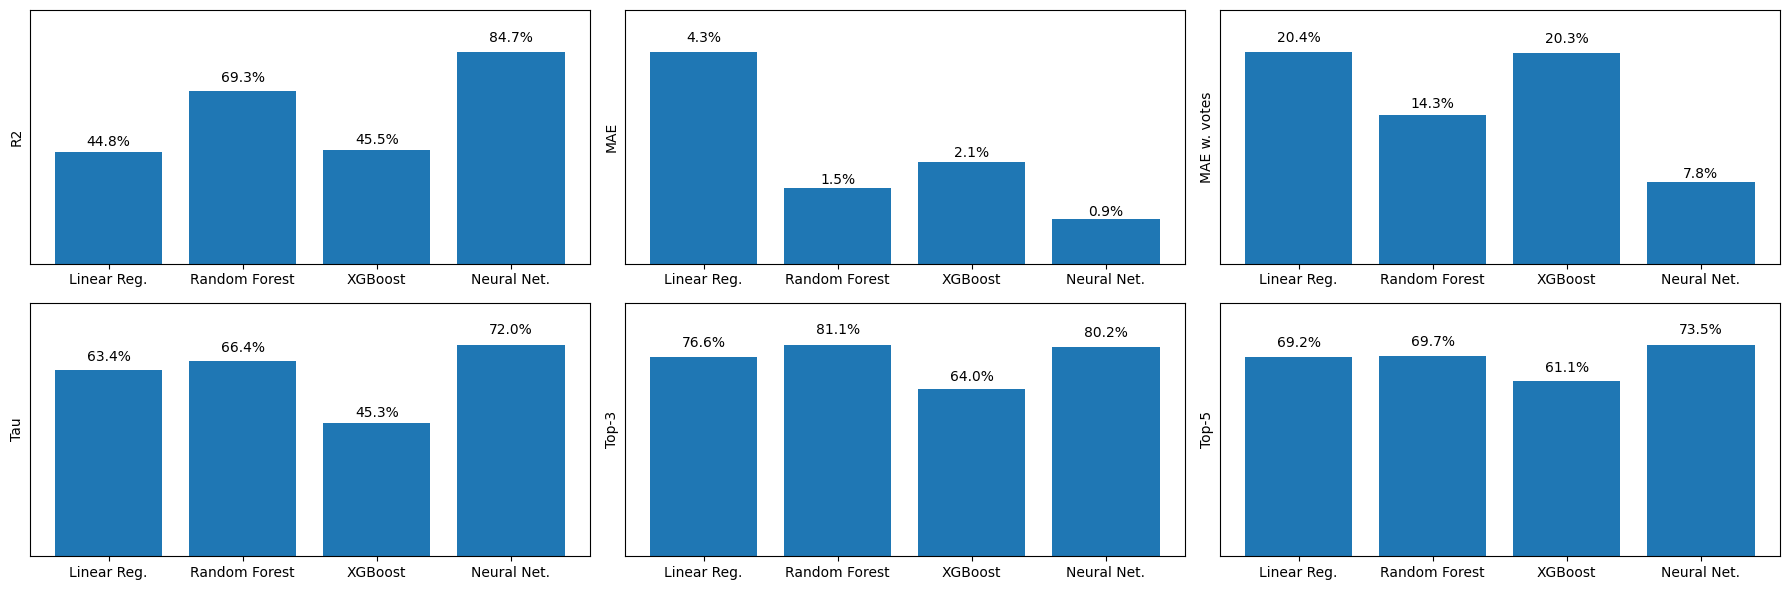

In [22]:
_, axs = plt.subplots(2, 3, figsize = (18, 6)); axs = axs.flatten()

for name, bt in zip(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'], [backtest_lr, backtest_rf, backtest_xg, backtest_nn]) :
    print(f'{name} :  {round(100*bt['Correct'].mean(), 1)}%')

for ax, metric in zip(axs, backtest_lr.columns[-6:]) :

    ax.bar(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'],
           [bt[metric].mean() for bt in [backtest_lr, backtest_rf, backtest_xg, backtest_nn]])
    
    for i, (name, bt) in enumerate(zip(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'], [backtest_lr, backtest_rf, backtest_xg, backtest_nn])) :
        ax.text(i, 1.05 * bt[metric].mean(),  str(round(100 * bt[metric].mean(), 1)) + '%', ha = 'center')

    
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1.2 * max([bt[metric].mean() for bt in [backtest_lr, backtest_rf, backtest_xg, backtest_nn]])])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [23]:
backtest_rf

,Winner,Pred. share,Pred. rank,Pred. winner,Share,Rank,Correct,R2,MAE,MAE w. votes,Tau,Top-3,Top-5
Year,,,,,,,,,,,,,
1988,Mark Jackson,0.365456,1,Mark Jackson,0.963,1,True,0.571767,0.021554,0.178700,0.707107,0.333333,0.4
1989,Mitch Richmond,0.328232,1,Mitch Richmond,0.941,1,True,0.552284,0.014855,0.251816,1.000000,0.666667,0.4
1990,David Robinson,0.764276,1,David Robinson,1.000,1,True,0.925252,0.006973,0.235724,NaN,0.333333,0.2
1991,Derrick Coleman,0.826424,1,Derrick Coleman,0.719,1,True,0.726512,0.014219,0.090274,1.000000,0.666667,0.4
1992,Larry Johnson,0.774028,1,Larry Johnson,0.943,1,True,0.891766,0.009599,0.152315,1.000000,1.000000,0.6
1993,Shaquille O'Neal,0.772316,1,Shaquille O'Neal,0.980,1,True,0.949746,0.005827,0.137178,1.000000,0.666667,0.4
1994,Chris Webber,0.604920,1,Chris Webber,0.525,1,True,0.698119,0.010863,0.185988,0.333333,1.000000,0.6
1995,Grant Hill,0.097513,2,Glenn Robinson,0.143,3,False,0.155893,0.019527,0.161177,0.501280,1.000000,0.8
1996,Damon Stoudamire,0.309876,2,Arvydas Sabonis,0.150,2,False,0.460582,0.017301,0.164093,0.552052,0.666667,1.0
